# Assignment: Подробнее о методах кластеризации

Представим, что международное круизное агентство "Carnival Cruise Line" решило себя разрекламировать с помощью баннеров и обратилось для этого к Вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с Вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры - легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях - Foursqare.

Часть открытых данных есть, например, на сайте archive.org:

https://archive.org/details/201309_foursquare_dataset_umn

Скачаем любым удобным образом архив с этой страницы.

Нас будет интересовать файл `checkins.dat`. Открыв его, увидим следующую структуру:

```
id | user_id | venue_id | latitude | longitude | created_at

---------+---------+----------+-------------------+-------------------+---------------------

984301 | 2041916 | 5222 | | | 2012-04-21 17:39:01

984222 | 15824 | 5222 | 38.8951118 | -77.0363658 | 2012-04-21 17:43:47

984315 | 1764391 | 5222 | | | 2012-04-21 17:37:18

984234 | 44652 | 5222 | 33.800745 | -84.41052 | 2012-04-21 17:43:43

...
```

Для удобной работы с этим документом преобразуем его к формату csv, удалив строки не содержащие координат - они неинформативны для нас:

```
id,user_id,venue_id,latitude,longitude,created_at

984222,15824,5222,38.8951118,-77.0363658,2012-04-21T17:43:47

984234,44652,5222,33.800745,-84.41052,2012-04-21T17:43:43

984291,105054,5222,45.5234515,-122.6762071,2012-04-21T17:39:22

...
```

С помощью `pandas` построим DataFrame и убедимся, что все 396632 строк с координатами считаны успешно.

In [1]:
import pandas as pd
df = pd.read_csv('checkins.csv')

In [2]:
df.head()

,id,user_id,venue_id,latitude,longitude,created_at
0,984222,15824.0,5222.0,38.895112,-77.036366,2012-04-21 17:43:47
1,984234,44652.0,5222.0,33.800745,-84.410520,2012-04-21 17:43:43
2,984291,105054.0,5222.0,45.523452,-122.676207,2012-04-21 17:39:22
3,984318,2146539.0,5222.0,40.764462,-111.904565,2012-04-21 17:35:46
4,984232,93870.0,380645.0,33.448377,-112.074037,2012-04-21 17:38:18


In [3]:
df.shape

(396634, 6)

In [4]:
df.tail()

,id,user_id,venue_id,latitude,longitude,created_at
396629,955561,626076.0,20073.0,40.850100,-73.866246,2012-04-13 09:56:48
396630,955892,674797.0,2297.0,33.748995,-84.387982,2012-04-13 10:56:03
396631,956377,845102.0,11195.0,42.765366,-71.467566,2012-04-13 12:08:45
396632,956119,1139114.0,29488.0,42.439479,-83.743830,2012-04-13 11:36:44
396633,956733,960666.0,60.0,42.331427,-83.045754,2012-04-13 21:56:19


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396634 entries, 0 to 396633
Data columns (total 6 columns):
id            396634 non-null int64
user_id       396634 non-null float64
venue_id      396634 non-null float64
latitude      396634 non-null float64
longitude     396634 non-null float64
created_at    396634 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 18.2+ MB


In [6]:
X = df[['latitude','longitude']]

Теперь необходимо кластеризовать данные координаты, чтобы выявить центры скоплений туристов. Поскольку баннеры имеют сравнительно небольшую площадь действия, нам нужен алгоритм, позволяющий ограничить размер кластера и не зависящий от количества кластеров.

Эта задача - хороший повод познакомиться с алгоритмом `MeanShift`, который мы обошли стороной в основной части лекций. Его описание при желании можно посмотреть в [sklearn user guide](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html), а чуть позже появится дополнительное видео с обзором этого и некоторых других алгоритмов кластеризации. Используйте `MeanShift`, указав `bandwidth=0.1`, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах.

**Примечание**: на 396632 строках, кластеризация будет работать долго. Для получения корректного ответа достаточно и 100000 (~2 минуты на "среднем" ноутбуке). Быть очень терпеливым не возбраняется - результат от этого только улучшится.

In [10]:
%%time
from sklearn import cluster
clt = cluster.MeanShift(bandwidth = 0.1)
clt.fit(X)

CPU times: user 45min 53s, sys: 2.26 s, total: 45min 55s
Wall time: 46min 1s


In [79]:
len(clt.cluster_centers_)

5536

Некоторые из получившихся кластеров содержат слишком мало точек - такие кластеры не интересны рекламодателям. Поэтому надо определить, какие из кластеров содержат, скажем, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения.

In [80]:
labels = clt.labels_
from collections import Counter
freq = list(Counter(labels).items())
norm_clt = [item[0] for item in freq if item[1] > 15]
print(len(norm_clt))
print(norm_clt[-50:])

1304
[1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1275, 1277, 1278, 1279, 1280, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1297, 1301, 1307, 1319, 1334, 1336, 1451, 1466, 1518, 1537, 1550, 1590, 1615, 1622, 1931, 2012, 2322, 2826, 3720, 3785, 4685]


In [81]:
centers = clt.cluster_centers_[norm_clt]
print(len(centers))
centers

1304


array([[  40.71748459,  -73.98935883],
       [  33.44969472, -112.0025631 ],
       [  41.87816455,  -87.6298271 ],
       ..., 
       [  42.0978027 ,  -88.5303643 ],
       [  14.45763885,  120.8901389 ],
       [  40.1109255 ,  -77.034978  ]])

При желании увидеть получившиеся результаты на карте, можно передать центры получившихся кластеров в один из инструментов визуализации. Например, сайт `mapcustomizer.com` имеет функцию Bulk Entry, куда можно вставить центры полученных кластеров в формате:

```
38.8951118,-77.0363658

33.800745,-84.41052

45.5234515,-122.6762071

...
```

Как мы помним, 20 баннеров надо разместить близ офисов компании. Найдем на Google Maps по запросу "Carnival Cruise Line" адреса офисов:

```
33.751277, -118.188740 (Los Angeles)

25.867736, -80.324116 (Miami)

51.503016, -0.075479 (London)

52.378894, 4.885084 (Amsterdam)

39.366487, 117.036146 (Beijing)

-33.868457, 151.205134 (Sydney)
```

Осталось определить 20 ближайших к ним центров кластеров. Т.е. посчитать дистанцию до ближайшего офиса для каждой точки и выбрать 20 с наименьшим значением.

**Примечание**: при подсчете расстояний и в кластеризации можно пренебречь тем, что Земля круглая, так как в точках, расположенных близко друг к другу погрешность мала, а в остальных точках значение достаточно велико, чтобы не повлиять на кластеризацию или сортировку.

In [82]:
import numpy as np
ofices = np.array([[33.751277,-118.188740],[25.867736, -80.324116],[51.503016, -0.075479],
                  [52.378894, 4.885084],[39.366487, 117.036146],[-33.868457, 151.205134]])

In [83]:
results = [ ]
for item in ofices:
    for jtem in centers:
        cur_rast = float(np.linalg.norm(jtem - item,ord=2))
        trio = (cur_rast,jtem,item)
        results.append(trio)

In [84]:
len(results)

7824

In [85]:
results[0]

(44.74498121705711,
 array([ 40.71748459, -73.98935883]),
 array([  33.751277, -118.18874 ]))

In [86]:
results.sort()
bests_20 = results[:20]

In [87]:
bests_20[:5]

[(0.003022703449948845,
  array([ -33.86614607,  151.20708242]),
  array([ -33.868457,  151.205134])),
 (0.009624603275668695,
  array([ 52.37248935,   4.89226825]),
  array([ 52.378894,   4.885084])),
 (0.025083985626543605,
  array([ 25.84620622, -80.31124452]),
  array([ 25.867736, -80.324116])),
 (0.05163441574703833,
  array([ 51.50305542,  -0.1271134 ]),
  array([ 51.503016,  -0.075479])),
 (0.07464357860975084,
  array([  33.81127536, -118.14433437]),
  array([  33.751277, -118.18874 ]))]

Предположим, вы получили итоговые 20 точек в следующем виде:

```
latitude, longitude

2.2,-2.2

3.3,-3.3

1.1,-0.1

1.1,-1.1

…

19.19,-19.19
```

Отсортируйте полученный список пар (широта, долгота) по возрастанию (пары сравниваются сначала по первому элементу, затем по второму):

```
latitude, longitude

1.1,-1.1

1.1,-0.1

2.2,-2.2

3.3,-3.3

…

19.19,-19.19
```

In [91]:
coord = [[item[1][0],item[1][1]] for item in bests_20]
coord.sort()
coord

[[-33.866146066197132, 151.20708241502382],
 [25.787086104201528, -80.215127572339213],
 [25.846206222222165, -80.311244519752975],
 [26.005051984048166, -80.205598124013619],
 [26.108543424509275, -80.158582412553287],
 [26.139268115151499, -80.336707563636324],
 [26.202449438484077, -80.244157586297462],
 [33.67523501694324, -117.85445502716857],
 [33.811275363621299, -118.14433436758206],
 [33.816964623699938, -117.89369495186592],
 [33.898487623211686, -118.06225896072969],
 [33.922035331177227, -118.414390270794],
 [34.011355508289746, -117.92150530090264],
 [34.064978390568754, -118.26547835472107],
 [34.070045516863743, -118.02395712702904],
 [51.480365858823511, -0.30832346176470588],
 [51.503055423520586, -0.12711340069686125],
 [51.598314025925916, -0.3217856185185185],
 [52.081999449999969, 5.0963915038461529],
 [52.372489349056607, 4.8922682490566016]]

In [33]:
len(coord)

20

В итоговый файл с ответами выведите по очереди широту и долготу каждой точки (в том же порядке), получив одну строчку из 40 чисел, разделенных пробелами:

`1.1 -1.1 1.1 -0.1 2.2 -2.2 3.3 -3.3 … 19.19 -19.19`

In [34]:
a = ' '.join(map(str,[' '.join(map(str, item)) for item in coord]))
a

'-33.8661460662 151.207082415 25.7870861042 -80.2151275723 25.8968964535 -80.2977115462 26.005051984 -80.205598124 26.119457017 -80.3925599489 26.1220444459 -80.1597755762 26.2024494385 -80.2441575863 33.7028001848 -117.893328782 33.8112753636 -118.144334368 33.811722707 -117.893651041 33.8720129077 -118.370344939 33.8763283672 -118.067409714 34.0113555083 -117.921505301 34.0335937724 -118.436591225 34.0649783906 -118.265478355 34.1331990344 -118.16562962 51.4856247143 -0.391046492857 51.5030554235 -0.127113400697 52.08199945 5.09639150385 52.3724893491 4.89226824906'

In [ ]:
with open("1.txt", "w") as fout:
        fout.write(a)

# Альтернативный кластеризатор

In [92]:
%%time
from sklearn import cluster
clt2 = cluster.MeanShift(bandwidth=0.1, bin_seeding=True, min_bin_freq=15)
clt2.fit(X)

CPU times: user 2.83 s, sys: 56 ms, total: 2.89 s
Wall time: 2.85 s


In [93]:
len(clt2.cluster_centers_)

524

In [94]:
centers2 = clt2.cluster_centers_
print(len(centers2))
centers2

524


array([[  40.7177164 ,  -73.99183542],
       [  33.44638027, -111.90188756],
       [  33.44841049, -112.07400428],
       ..., 
       [  34.5794343 , -118.1164613 ],
       [  29.7030024 ,  -98.1244531 ],
       [  41.4730948 ,  -87.0611412 ]])

In [95]:
import numpy as np
ofices = np.array([[33.751277,-118.188740],[25.867736, -80.324116],[51.503016, -0.075479],
                  [52.378894, 4.885084],[39.366487, 117.036146],[-33.868457, 151.205134]])

In [96]:
results2 = [ ]
for item in ofices:
    for jtem in centers2:
        cur_rast = float(np.linalg.norm(jtem - item,ord=2))
        trio = (cur_rast,jtem,item)
        results2.append(trio)

In [97]:
len(results2)

3144

In [98]:
results2[0]

(44.74257091784804,
 array([ 40.7177164 , -73.99183542]),
 array([  33.751277, -118.18874 ]))

In [99]:
results2.sort()
bests_202 = results2[:20]

In [100]:
bests_202[:5]

[(0.007834758163107856,
  array([ -33.86063043,  151.20477593]),
  array([ -33.868457,  151.205134])),
 (0.009353316185992226,
  array([ 52.37296399,   4.89231722]),
  array([ 52.378894,   4.885084])),
 (0.022358439051973395,
  array([ 25.88305038, -80.30782583]),
  array([ 25.867736, -80.324116])),
 (0.05005829482278787,
  array([ 51.50299126,  -0.12553729]),
  array([ 51.503016,  -0.075479])),
 (0.06476318841858848,
  array([  33.80646455, -118.15484893]),
  array([  33.751277, -118.18874 ]))]

In [101]:
coord2 = [[item[1][0],item[1][1]] for item in bests_202]
coord2.sort()
coord2

[[-33.860630428571433, 151.20477592857145],
 [25.705349721052592, -80.28342873815798],
 [25.785812419967499, -80.217938036825402],
 [25.883050377499991, -80.307825830000013],
 [26.010098249285683, -80.199990585714318],
 [26.120862658633104, -80.158906680215694],
 [26.20058464102565, -80.250716125641006],
 [33.64320486829282, -117.9461146118902],
 [33.731744235999898, -117.82570046023532],
 [33.806464550704142, -118.15484892711318],
 [33.811233140199242, -117.89061154568174],
 [33.872986011570177, -118.36209114655645],
 [33.888325342758598, -118.04892817172427],
 [34.035486953121158, -118.43899771946148],
 [34.060397554582408, -118.24870902659876],
 [34.097019514285769, -117.9960914164017],
 [34.125047479062147, -118.34272233171858],
 [34.138009309227201, -118.16898671183529],
 [51.502991260887086, -0.12553728870967767],
 [52.37296399032261, 4.8923172225806466]]

In [49]:
a1 = ' '.join(map(str,[' '.join(map(str, item)) for item in coord2]))
a1

'-33.8661460662 151.207082415 25.7870861042 -80.2151275723 25.8968964535 -80.2977115462 26.005051984 -80.205598124 26.119457017 -80.3925599489 26.1220444459 -80.1597755762 26.2024494385 -80.2441575863 33.7028001848 -117.893328782 33.8112753636 -118.144334368 33.811722707 -117.893651041 33.8720129077 -118.370344939 33.8763283672 -118.067409714 34.0113555083 -117.921505301 34.0335937724 -118.436591225 34.0649783906 -118.265478355 34.1331990344 -118.16562962 51.4856247143 -0.391046492857 51.5030554235 -0.127113400697 52.08199945 5.09639150385 52.3724893491 4.89226824906'

In [50]:
a

'-33.8661460662 151.207082415 25.7870861042 -80.2151275723 25.8968964535 -80.2977115462 26.005051984 -80.205598124 26.119457017 -80.3925599489 26.1220444459 -80.1597755762 26.2024494385 -80.2441575863 33.7028001848 -117.893328782 33.8112753636 -118.144334368 33.811722707 -117.893651041 33.8720129077 -118.370344939 33.8763283672 -118.067409714 34.0113555083 -117.921505301 34.0335937724 -118.436591225 34.0649783906 -118.265478355 34.1331990344 -118.16562962 51.4856247143 -0.391046492857 51.5030554235 -0.127113400697 52.08199945 5.09639150385 52.3724893491 4.89226824906'

In [ ]:
with open("1.txt", "w") as fout:
        fout.write(a)

Populating the interactive namespace from numpy and matplotlib
(100000,)


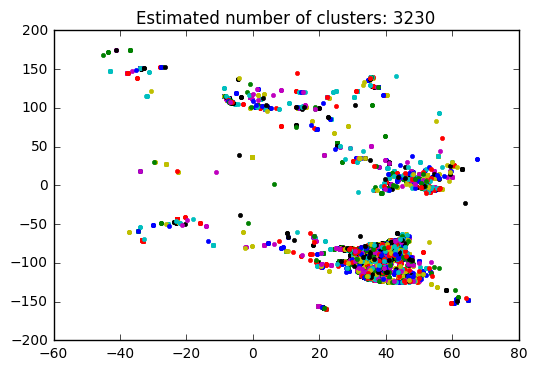

In [51]:
%pylab inline
import pandas as pd
import sklearn.cluster as sk
import matplotlib.pyplot as plt
from itertools import cycle

dataset=pd.read_csv('checkins.csv')
newdataset=dataset.head(100000)
X=np.array((newdataset['latitude'],newdataset['longitude']))
X=X.T

ms=sk.MeanShift(bandwidth=0.1)
ms.fit(X)
       
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

plt.figure(1)
plt.clf()

print labels.shape 

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members,0],X[my_members,1],col + '.' )#Пространство признаков с выделенными разными цветами кластерами
    #plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
           #  markeredgecolor='k', markersize=14)#центры кластеров
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()